# 聚类算法实践
- Kmeans与Dbscan算法
- 半监督问题解决方案
- 聚类评估方法

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt

np.random.seed(42)

## Kmeans
- y只是参考，这是无监督任务
- `y=None`是为了使颜色都一样；c参数是一个标量，所有绘制为相同颜色，数组（与数据点数量相同）则为每个店都赋予一个颜色

In [6]:
from sklearn.datasets import make_blobs

# 质心
blob_centers = np.array(
    [[0.2, 2.3],
     [-1.5,2.3],
     [-2.8,1.8],
     [-2.8,2.8],
     [-2.8,1.3]]
)

# 发散程度
blob_std = np.array([0.4,0.3,0.1,0.1,0.1])

X, y = make_blobs(n_samples=2000, centers=blob_centers, cluster_std=blob_std, random_state=7)
print(X.shape)

(2000, 2)


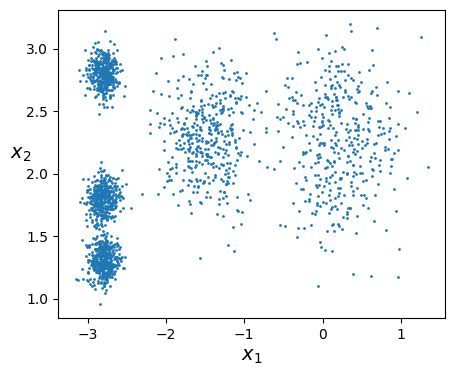

In [8]:
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)
    
plt.figure(figsize=(5, 4))
plot_clusters(X)
plt.show()

### 决策边界
- `kmeans.fit_predict(X)`与`kmeans.labels_`得到的预测结果是一致的
- `X.min(axis=0)`返回的是数组
- `kmeans.transform`得到样本点到每个质点的**距离**

In [59]:
from sklearn.cluster import KMeans

k = 5
kmeans = KMeans(n_clusters=k, n_init=10, random_state=2)
y_pred = kmeans.fit_predict(X) 

# print(kmeans.labels_, kmeans.cluster_centers_)

In [60]:
x_test = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
kmeans.predict(x_test)

array([0, 0, 2, 2])

#### 绘制**决策边界**
- 如果不需要精确控制网格点的坐标分布，省略 xx 和 yy 是可以的，只要你提供了 extent 参数


In [78]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

# 使用了叠加绘制
def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    # 根据权重过滤质心，只绘制那些权重大于最大权重 1/10 的质心
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=2,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=1,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True, show_xlabels=True, show_ylabels=True):
    # 使用棋盘
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution), 
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.flatten(), yy.flatten()])
    Z = Z.reshape(xx.shape)


    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')
 
    # plt.contourf(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), cmap="Pastel2")
    # plt.contour(xx, yy, Z, extent=(mins[0], maxs[0], mins[1], maxs[1]), linewidths=1, colors='k')

    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_) #clusterer是聚类算法
    
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft='off')

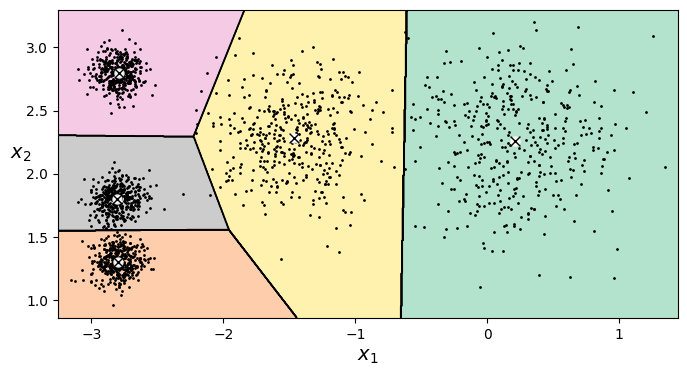

In [79]:
plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [80]:
kmeans.transform(x_test)

array([[0.32995317, 2.88633901, 2.9042344 , 1.49439034, 2.81093633],
       [2.80290755, 5.84236351, 5.84739223, 4.4759332 , 5.80730058],
       [3.29399768, 1.71086031, 0.29040966, 1.69136631, 1.21475352],
       [3.21806371, 1.21567622, 0.36159148, 1.54808703, 0.72581411]])

### 算法流程
通过画图得到kmeans的每一步过程：  
随着迭代次数的增加，质心如何逐步调整并收敛到稳定状态
- 设置**随机种子**，保证每次运行时，随机初始化的结果都是可重复的，对`init='random'很重要，保证每次随机初始化的结果一致

In [81]:
kmeans_iter1 = KMeans(n_clusters=5, init='random', n_init=1, max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init='random', n_init=1, max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init='random', n_init=1, max_iter=3, random_state=1)

kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(init='random', max_iter=3, n_clusters=5, n_init=1, random_state=1)

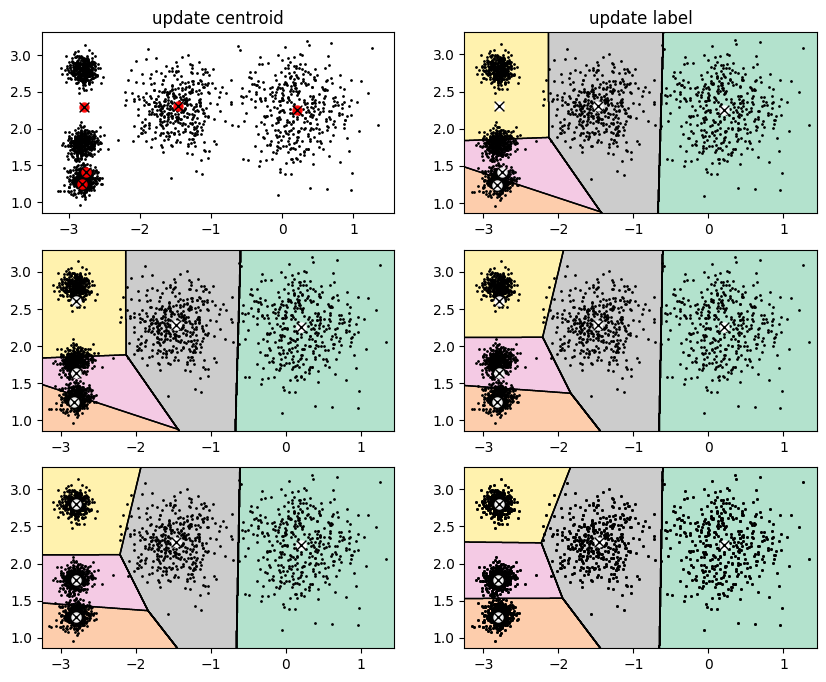

In [86]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='k')
plt.title('update centroid')  # 只需要写这一次

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title('update label')  # 只需要写这一次

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False, show_ylabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X,  show_centroids=False, show_xlabels=False, show_ylabels=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_data(X)
plot_decision_boundaries(kmeans_iter3, X, show_xlabels=False, show_ylabels=False)

plt.show()

### 不稳定的结果
对比实验

In [87]:
def plot_clusterer_comparision(c1, c2, X):
    c1.fit(X)
    c2.fit(X)

    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plot_decision_boundaries(c1, X)
    plt.subplot(122)
    plot_decision_boundaries(c2, X)

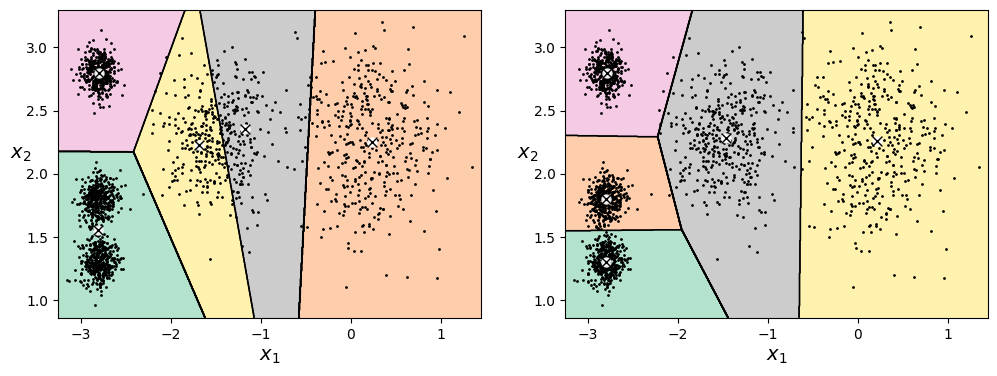

In [89]:
c1 = KMeans(n_clusters=5, init='random', n_init=1, random_state=99)
c2 = KMeans(n_clusters=5, init='random', n_init=1, random_state=19)

plot_clusterer_comparision(c1, c2, X)

## 评估方法(只供参考)

### 1.Inertia指标：
- 每个样本与质心的距离，属性：`.inertia_`   
- Sum of squared distances of samples to their closest cluster center, weighted by the sample weights if provided

In [90]:
kmeans.inertia_

211.59853725816836

In [100]:
x_dist = kmeans.transform(X)
print(x_dist)

[[3.04611916 0.11146795 1.45402521 1.54944305 0.46779778]
 [3.11541584 0.51431557 0.99002955 1.48612753 0.07122059]
 [1.32016676 3.76340605 4.09069201 2.67154781 3.81713488]
 ...
 [3.04886464 1.42865797 0.06769209 1.40795651 0.92830156]
 [0.14895409 3.23385668 3.05913478 1.71125    3.10300136]
 [2.8625311  0.67518173 0.85434589 1.21678483 0.22700281]]


In [97]:
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print(labels.shape, centroids.shape)

(2000,) (5, 2)


inertia指标的计算

In [99]:
X_dist = x_dist[range(len(labels)), labels]
inertia = np.sum(X_dist ** 2)
print(inertia)

211.59853725816856


In [101]:
kmeans.score(X)

-211.59853725816834

In [102]:
print(c1.inertia_, c2.inertia_)

237.02727177689724 211.59853725816836


### 找到最佳簇数
- 如果k值越大，得到的inertia指标越小
- 找**拐点**——**肘部法则**：inertia指标在一定的k值后，误差的减小幅度会明显变小，这个点就是最佳的簇数

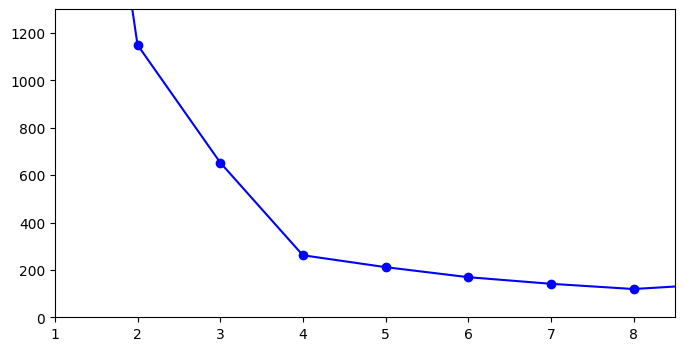

In [106]:
kmeans_models = [KMeans(n_clusters=k, init='random', n_init='auto').fit(X) for k in range(1, 10)]

intertias = [model.inertia_ for model in kmeans_models]

plt.figure(figsize=(8, 4))
plt.plot(range(1, 10), intertias, 'b-o')
plt.axis([1,8.5,0,1300])
plt.show()

### 2.轮廓系数 **silhouette_score**
- ai：计算样本i到同簇其他样本的平均距离；越小说明样本i越应该被聚类到该簇；将ai成为样本i的簇内不相似度
- bi：计算样本i到其他某簇Cj的所有样本的平均距离bij，称为样本i与簇Cj的不相似度；定义为样本i的簇间不相似度：bi=min{bi1, bi2, ..., bik}
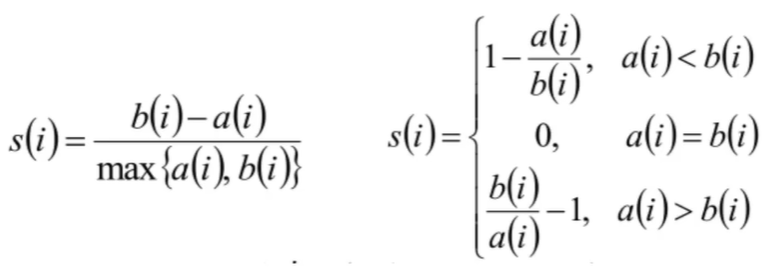
结论：
- si接近1，则说明样本i聚类合理
- si接近-1，则说明样本i更应该分类到另外的簇
- 若si近似为0，则说明样本i在两个簇的边界上

In [108]:
from sklearn.metrics import silhouette_score

silhouette_score(X, kmeans.labels_)

0.655517642572828

- **Note** that Silhouette Coefficient is only defined if number of labels is **2 <= n_labels <= (n_samples - 1)**

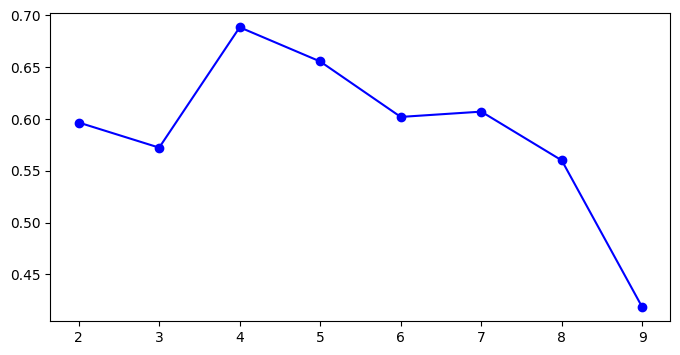

In [114]:
silhouette_scores = [silhouette_score(X, model.labels_)for model in kmeans_models[1:]]

plt.figure(figsize=(8, 4))
plt.plot(range(2, 10), silhouette_scores, 'b-o')
plt.show()

### Kmeans存在的问题
初始点影响很大

(250, 2) (250,)


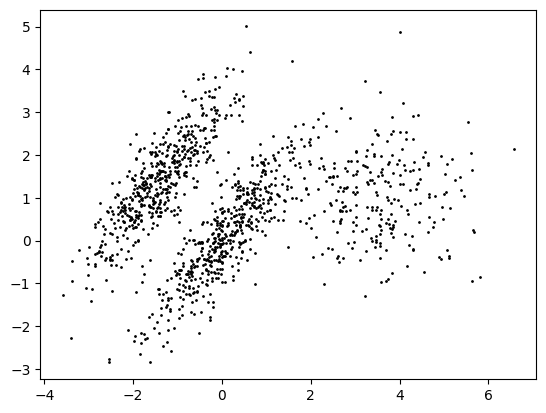

In [117]:
X1, y1 = make_blobs(n_samples=1000, centers=((4, -4), (0, 0)), random_state=42)

# 对 X1 进行线性变换
X1 = X1.dot(np.array([[0.374, 0.95], [0.732, 0.598]]))

X2, y2 = make_blobs(n_samples=250, centers=1, random_state=42) # 只有一个簇
print(X2.shape, y2.shape)

# 对X2进行平移
X2 = X2 + [6, -8]

X = np.r_[X1, X2]
y = np.r_[y1, y2]

plot_data(X)

In [137]:
kmeans_good = KMeans(n_clusters=3, init=np.array([[-1.5,2.5],[0.5,0],[4,0]]), n_init=1, random_state=42)
kmeans_bad = KMeans(n_clusters=3, n_init=10, random_state=42)

kmeans_good.fit(X)
kmeans_bad.fit(X)

KMeans(n_clusters=3, n_init=10, random_state=42)

Text(0.5, 1.0, 'Bad - Inertia =2179.6411978716374')

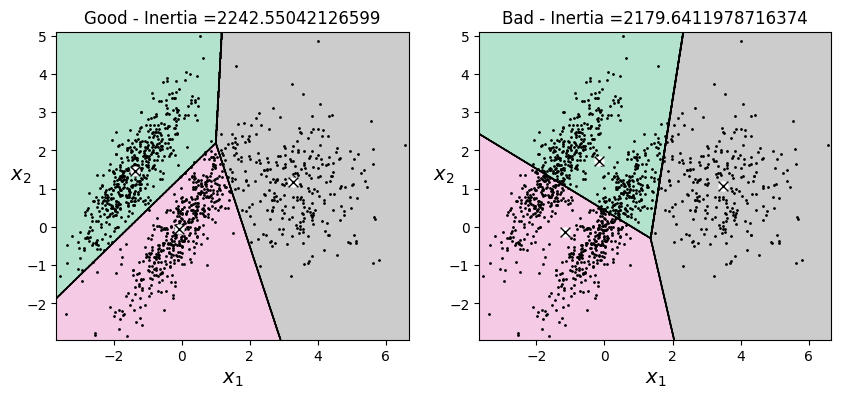

In [138]:
plt.figure(figsize=(10, 4))
plt.subplot(121)
plot_decision_boundaries(kmeans_good, X)
plt.title('Good - Inertia ={}'.format(kmeans_good.inertia_))

plt.subplot(122)
plot_decision_boundaries(kmeans_bad, X)
plt.title('Bad - Inertia ={}'.format(kmeans_bad.inertia_))

### 图像分割

In [139]:
from matplotlib.image import imread
image = imread('ladybug.png')
image.shape

(533, 800, 3)

KMeans的输入是二维数组 (n_samples, n_features)  
image的形状是(533, 800, 3)，3是像素通道 

In [140]:
X = image.reshape(-1, 3)
X.shape

(426400, 3)

In [148]:
kmeans = KMeans(n_clusters=8, n_init=10, random_state=42).fit(X)

centroids = kmeans.cluster_centers_
print(centroids)

[[0.02201948 0.10826439 0.00567489]
 [0.98317236 0.93281454 0.02554234]
 [0.2132549  0.38074106 0.05517892]
 [0.6083286  0.62859994 0.38572747]
 [0.3667758  0.51952744 0.1532005 ]
 [0.09565558 0.24867335 0.0160392 ]
 [0.76499236 0.19946557 0.04393002]
 [0.87636715 0.71767735 0.0367492 ]]


In [143]:
kmeans.labels_

array([0, 0, 0, ..., 5, 5, 0])

得到的对应于图片，所有只有8种像素点

In [154]:
segment_img = centroids[kmeans.labels_].reshape(image.shape)
segment_img.shape

(533, 800, 3)

In [158]:
segment_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_cluster in n_colors:
    kmeans = KMeans(n_clusters=n_cluster, n_init=10, random_state=42).fit(X)
    segment_imgs.append(kmeans.cluster_centers_[kmeans.labels_].reshape(image.shape))

In [160]:
len(segment_imgs)

5

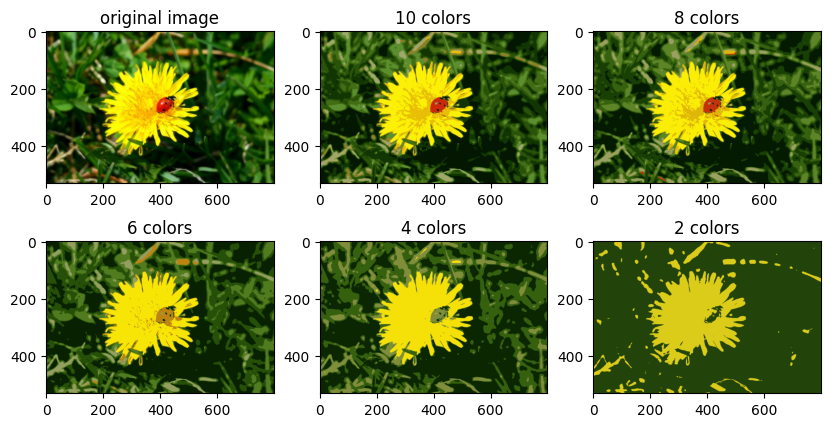

In [162]:
plt.figure(figsize=(10, 5))
plt.subplot(231)
plt.imshow(image)
plt.title('original image')

# for index, segment_img in enumerate(segment_imgs):
#     plt.subplot(2, 3, index+2)
#     plt.imshow(n_cluster)

for index, n_cluster in enumerate(n_colors):
    plt.subplot(2, 3, 2 + index)
    plt.imshow(segment_imgs[index])
    plt.title('{} colors'.format(n_cluster))

plt.show()
    
    

### 半监督学习
先将训练集聚类为50个集群，然后对每个聚类，找到最靠近质心的图像，将这些图像称为代表性图像
- `load_digits`是一个用于手写数字识别的数据集，包含1797个8*8像素的手写数字图片

In [164]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

X_digits, y_digits = load_digits(return_X_y=True)
print(X_digits.shape, y_digits.shape)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits, random_state=42)
print(X_train.shape)

(1797, 64) (1797,)
(1347, 64)


- 只有50个样本有标签，这50个样本是随机选择得到的，结果在训练集上正确率较低

In [170]:
from sklearn.linear_model import LogisticRegression

n_labels = 50
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train[:n_examples], y_train[:n_examples])

log_reg.score(X_test, y_test)

0.8222222222222222

- 更好的是得到有代表性的50个样本点(离50个簇质心最小的50个样本)

In [172]:
k = 50
kmeans = KMeans(n_clusters=50, n_init=10, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
print(X_digits_dist.shape)

(1347, 50)


In [173]:
representative_digits_idx = np.argmin(X_digits_dist, axis=0)
print(representative_digits_idx.shape)

(50,)


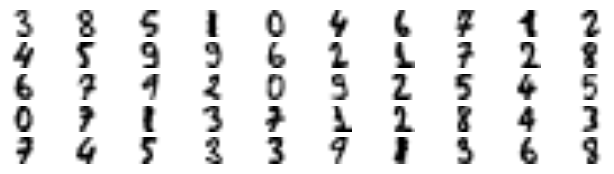

In [175]:
X_representative_digits = X_train[representative_digits_idx]

plt.figure(figsize=(8, 2))
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k//10, 10, index+1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')
    
plt.show()

In [179]:
print(y_train[representative_digits_idx]) 
y_representative_digits = np.array([
    3, 8, 5, 1, 0, 4, 6, 7, 1, 2,
    4, 5, 9, 9, 6, 2, 1, 8, 2, 8,
    6, 7, 9, 2, 0, 9, 2, 5, 4, 5,
    0, 7, 1, 3, 7, 1, 2, 8, 4, 3,
    7, 4, 5, 3, 3, 9, 1, 3, 6, 8])
y_representative_digits == y_train[representative_digits_idx]

[3 8 5 1 0 4 6 7 1 2 4 5 9 9 6 2 1 7 2 8 6 7 9 2 0 9 2 5 4 5 0 7 1 3 7 1 2
 8 4 3 7 4 5 3 3 9 1 3 6 8]


array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True])

目前得到了一个只有50个标记实例的数据集，它们中的每一个都是器集群的代表性图像，而不是完全随机的实力，观察性能

In [181]:
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8866666666666667

- 更进一步：若将**标签传播**到同一集群集中的所有其他实例

In [186]:
y_train_propagated = np.empty(y_train.shape, dtype=int)

for i in range(k):
    y_train_propagated[kmeans.labels_ == i] = y_representative_digits[i]

log_reg = LogisticRegression(max_iter=10000, random_state=42)
log_reg.fit(X_train, y_train_propagated)

log_reg.score(X_test, y_test)

0.8822222222222222

- 只选择前20%来实验，余下的都标记为-1，是被忽略的
- 使用`np.percentile`
- `X_cluster_dist[above_cutoff & in_cluster] = -1`**注意**此书写方法

In [190]:
percentile_closest = 20

# 每个样本到所属簇质心的距离
X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]

# 筛选前20%的数据
for i in range(k):
    in_cluster = (kmeans.labels_ == i) 
    cluster_dist = X_cluster_dist[in_cluster] #选择属于当前簇的所有样本
    cutoff_distance = np.percentile(cluster_dist, percentile_closest) # 分位点
    
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[above_cutoff & in_cluster] = -1

partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train[partially_propagated]

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

log_reg.score(X_test, y_test)

0.9444444444444444

### DBSCAN

建数据集，使用**make_moons**

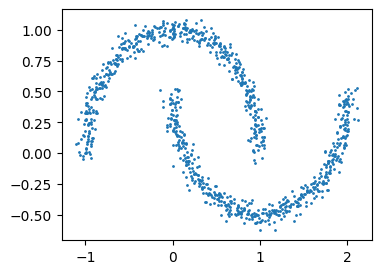

In [196]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plt.figure(figsize=(4, 3))
plt.scatter(X[:, 0], X[:, 1], s=1)

- **-1**表示离群点

In [203]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.05, min_samples=5)
dbscan.fit(X)

print(dbscan.labels_[:10], dbscan.core_sample_indices_[:10]) 

[ 0  2 -1 -1  1  0  0  0  2  5] [ 0  4  5  6  7  8 10 11 12 13]


In [205]:
n_clusters = len(np.unique(dbscan.labels_))
print(n_clusters)

8


In [206]:
dbscan2 = DBSCAN(eps = 0.2,min_samples=5)
dbscan2.fit(X)

DBSCAN(eps=0.2)

#### 作图对比，作图过程

In [225]:
def plot_dbscan(dbscan, X, size, show_xlabel=True, show_ylabel=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask  = (dbscan.labels_ == -1)
    non_core_mask = ~(core_mask | anomalies_mask) # 或运算，取反运算

    cores = dbscan.components_ # 核心点坐标
    # cores = X[core_mask]
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]

    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], c=dbscan.labels_[core_mask], marker='*', s=10)

    # 异常点 + 边缘点（非核心点）
    plt.scatter(anomalies[:, 0], anomalies[:, 1], c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")

    if show_xlabel:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom='off')
        
    if show_ylabel:
         plt.ylabel("$x_2$", fontsize=14, rotation=0) # rotation表示标签的旋转角度
    else:
        plt.tick_params(labelleft=False)

    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

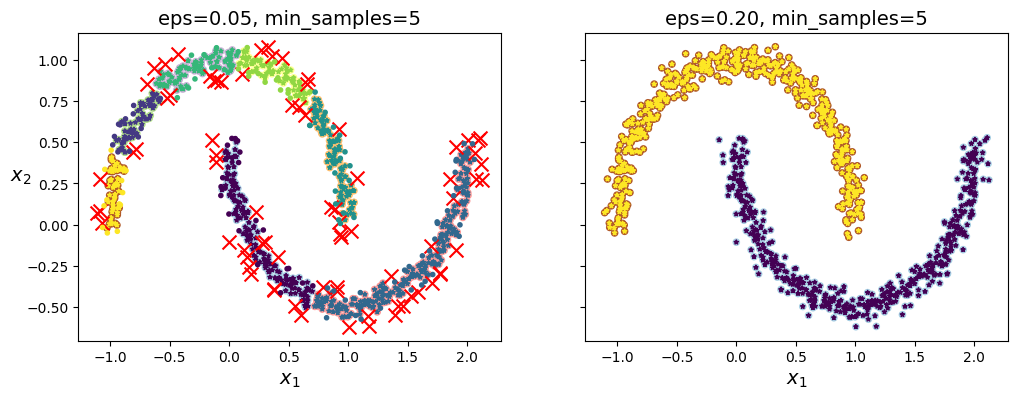

In [226]:
plt.figure(figsize=(12, 4))

plt.subplot(121)
plot_dbscan(dbscan, X, size=20)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=20, show_ylabel=False)

plt.show()